## モジュールをインポート

In [1]:
import os
import random
import math
from math import ceil
import itertools
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

## テスト時に画像を表示するための関数

In [44]:
'''
opencvの画像(BGR形式)をmatplotlibで表示するための関数
画像データ(numpy)を引数に与えるとそのまま表示
複数の画像データをリストに入れて与えると画像を横一列に表示
'''
def show_img(img):
    if 'list' in str(type(img)):
        print("img_len: " + str(len(img)))
        plt.figure(figsize=(18,18))
        for i,j in enumerate(img):
            plt.subplot(1,10,i+1)
            im_rgb = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
            plt.imshow(im_rgb,cmap='gray')
        plt.show()
    else:
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(im_rgb,cmap='gray')
        plt.show()

## 【画像処理の候補】
**処理の内容（関数名）**<br>
・移動（generate_slide_img）<br>
・文字の膨張（expansion）<br>
・コントラストを調整（contrast）<br>
・明るさを調整（ガンマ補正）（gamma）<br>
・平滑化（平均化フィルタ）（blur）<br>
・部分マスク（mask）<br>
・拡大縮小(リサイズ)（resize）<br>
・回転（rotate）<br>
・アフィン変換（歪み）（affine）<br>
・ノイズを増やす（gaussian_noise）<br><br>
**全て下に実装**<br>

## 各画像処理の関数

In [55]:
'''
文字を移動させた画像を生成する関数
８方向(上下左右＋斜め4方向)に移動した画像が出力される
画像を動かす度合いは任意の上限nまでの中からランダムに決まる
'''
def generate_slide_img(img):
    
    # 画像を動かす度合いの上限
    n = 6
    
    def slide_left(img):
        height, width = img.shape
        width_slide_area = int(width / n)
        # 左へスライド
        left_slide_value = random.randint(int(width_slide_area/2), width_slide_area)
        crop_left_img = img[:, left_slide_value:width]
        img_slided_left = cv2.copyMakeBorder(crop_left_img, 0, 0, 0, left_slide_value, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        img_slided_left = cv2.resize(img_slided_left, dsize=(height, width))
        return img_slided_left
    
    def slide_right(img):
        height, width = img.shape
        width_slide_area = int(width / n)
        # 右へスライド
        right_slide_value = random.randint(int(width_slide_area/2), width_slide_area)
        crop_right_img = img[:, 0:width-right_slide_value]
        img_slided_right = cv2.copyMakeBorder(crop_right_img, 0, 0, right_slide_value, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        img_slided_right = cv2.resize(img_slided_right, dsize=(height, width))
        return img_slided_right
    
    def slide_top(img):
        height, width = img.shape
        height_slide_area = int(height / n)
        # 上へスライド
        top_slide_value = random.randint(int(height_slide_area/2), height_slide_area)
        crop_top_img = img[top_slide_value:height, :]
        img_slided_top = cv2.copyMakeBorder(crop_top_img, 0, top_slide_value, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        img_slided_top = cv2.resize(img_slided_top, dsize=(height, width))
        return img_slided_top
    
    def slide_bottom(img):
        height, width = img.shape
        height_slide_area = int(height / n)
        # 下へスライド
        bottom_slide_value = random.randint(int(height_slide_area/2), height_slide_area)
        crop_bottom_img = img[0:height-bottom_slide_value, :]
        img_slided_bottom = cv2.copyMakeBorder(crop_bottom_img, bottom_slide_value, 0, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        img_slided_bottom = cv2.resize(img_slided_bottom, dsize=(height, width))
        return img_slided_bottom
    
    slide_left_img = slide_left(img)
    slide_right_img = slide_right(img)
    slide_top_img = slide_top(img)
    slide_bottom_img = slide_bottom(img)
    
    slide_left_top_img = slide_top(slide_left_img)
    slide_top_right_img = slide_right(slide_top_img)
    slide_right_bottom_img = slide_bottom(slide_right_img)
    slide_bottom_left_img = slide_left(slide_bottom_img)
    
    return [slide_left_img, slide_right_img, slide_top_img, slide_bottom_img, slide_left_top_img, slide_top_right_img, slide_right_bottom_img, slide_bottom_left_img]


In [56]:
'''
文字の膨張
白背景黒色文字の場合、文字を膨張させることができる
膨張の度合いはランダムに決まる
'''
def expansion(img):
    # 膨張の度合いの上限・下限はここを変更
    n = random.randint(2, 4)
    kernel = np.ones((n,n),np.uint8)
    expansion = cv2.erode(img,kernel,iterations = 1)
    
    return expansion


In [57]:
'''
コントラストを調整
'''
def contrast(img, alpha=1.0, beta=0.0):
    # 積和演算を行う。
    dst = alpha * img + beta
    # [0, 255] でクリップし、uint8 型にする。
    return np.clip(dst, 0, 255).astype(np.uint8)


In [74]:
'''
明るさを変換
ガンマ補正
'''
def gamma(img):
    gamma = random.uniform(0.5, 1.5)
    gamma_cvt = np.zeros((256,1), dtype=np.uint8)
    for i in range(256):
        gamma_cvt[i][0] = 255*(float(i)/255)**(1.0/gamma)
    return cv2.LUT(img, gamma_cvt)
    

In [59]:
'''
平滑化（平均化フィルタ）
ぼやけ度合いはランダムに決まる
'''
def blur(img):
    n = random.randint(2, 3) # 値が大きくなるほどぼやけが強くなる
    img_blur = cv2.blur(img, (n, n))
    
    return img_blur


In [60]:
'''
部分マスク
ランダムに１部分をボックスノイズにする
ボックスの大きさ、場所はランダムに決まる
'''
def mask(img):
    img_copy = np.copy(img)
    # ボックスの大きさ、場所はランダムに決まる
    # n: ボックスの大きさの上限を決める値 n=4の場合は1辺の大きさの最大値が画像の大きさの1/4となる
    n = 4
    height = random.randint(1, ceil(img.shape[0]/n))
    width = random.randint(1, ceil(img.shape[1]/n))
    y = random.randint(0, img.shape[0] - height)
    x = random.randint(0, img.shape[1] - width)
    
    # ノイズ画像の生成
    sig=100 # 標準偏差
    noise=np.random.normal(0,sig,(height, width))
    noise[noise>255]=255 # 255超える場合は255
    noise[noise<0]=0 # 0を下回る場合は0
    noise=noise.astype(np.uint8)
    #print(noise.shape) # デバッグ用
    #show_img(noise) # デバッグ用
    
    noise_mask = cv2.copyMakeBorder(noise, y, img.shape[0]-height-y, x, img.shape[0]-width-x, cv2.BORDER_CONSTANT, (0, 0, 0))
    noise_mask = cv2.resize(noise_mask, dsize=img.shape)
    #show_img(noise_mask) # デバッグ用
    
    cv2.rectangle(img_copy, pt1=(x, y), pt2=(x+width, y+height), color=(0, 0, 0), thickness=-1, lineType=cv2.LINE_4, shift=0)
    #show_img(img_copy) # デバッグ用
    
    masked_img = cv2.add(noise_mask, img_copy)
    #show_img(masked_img) # デバッグ用
    
    return masked_img


In [61]:
'''
拡大縮小(リサイズ)
ランダムに画像を拡大または縮小する
拡大または縮小の度合いはランダムに決まる
'''
def resize(img):
    h, w = img.shape
    
    # 元の大きさから必ず変化するランダム値を生成
    # サイズの最小値と最大値はここを変更
    n1 = random.randint(ceil(h*0.5), h-1)
    n2 = random.randint(h+1, ceil(h*1.5))
    n = random.choice([n1, n2])
    resize_img = cv2.resize(img, dsize=(n, n))
    
    # 画像が小さくなった場合 周りの値を白パディング
    if h > n:
        resize_img = cv2.copyMakeBorder(resize_img, ceil((h-n)/2), ceil((h-n)/2), ceil((h-n)/2), ceil((h-n)/2), cv2.BORDER_CONSTANT, value=(255, 255, 255))
        resize_img = cv2.resize(resize_img, dsize=(h, w))
    
    # 画像が大きくなった場合 元の大きさになるように画像の中央をクロップ
    elif h < n:
        resize_img = resize_img[ceil((n-h)/2):ceil((n-h)/2)+h, ceil((n-h)/2):ceil((n-h)/2)+w]
    
    return resize_img
    

In [62]:
'''
回転
白黒反転せさせてから回転させることで背景色を統一している
回転の度合いはランダムに決まる
'''
def rotate(img):
    height, width = img.shape[0], img.shape[1]
    center = (int(width/2), int(height/2))
    
    bitwise_img = cv2.bitwise_not(img)
    
    #回転角を指定　回転の度合いはランダムに決まる
    #上限と下限を変更したい場合はここの値を変更
    angle1 = random.randint(5.0, 15.0)
    angle2 = random.randint(345.0, 355.0)
    angle = random.choice([angle1, angle2])
    #スケールを指定
    scale = 1.0
    #getRotationMatrix2D関数を使用
    trans = cv2.getRotationMatrix2D(center, angle , scale)
    #アフィン変換
    rotate_img = cv2.warpAffine(bitwise_img, trans, (width,height))
    
    result_img = cv2.bitwise_not(rotate_img)
    
    return result_img


In [63]:
'''
アフィン変換（歪み）
歪みの値はランダムに決まる
'''
def affine(img):
    h, w = img.shape
    
    bitwise_img = cv2.bitwise_not(img)
    
    # 上限・下限はここの値を変更
    a = math.tan(math.radians(random.randint(-20, 20)))
    # x軸方向に歪ませる
    mat_x = np.array([[1, a, 0], [0, 1, 0]], dtype=np.float32)
    affine_img_skew_x = cv2.warpAffine(bitwise_img, mat_x, (int(w + h * a), h))
    affine_img_skew_x = cv2.resize(affine_img_skew_x, dsize=(h, w))
    
    a = math.tan(math.radians(random.randint(-20, 20)))
    # y軸方向に歪ませる
    mat_y = np.array([[1, 0, 0], [a, 1, 0]], dtype=np.float32)
    affine_img_skew_y = cv2.warpAffine(bitwise_img, mat_y, (w, int(h + w * a)))
    affine_img_skew_y = cv2.resize(affine_img_skew_y, dsize=(h, w))
    
    affine_img = random.choice([affine_img_skew_x, affine_img_skew_y])
    
    result_img = cv2.bitwise_not(affine_img)
    
    return result_img


In [64]:
'''
ノイズを増やす（ガウシアンノイズ）
'''
def gaussian_noise(img):
    sig=20 # 標準偏差
    noise=np.random.normal(0,sig,np.shape(img))
    noise_img = img+np.floor(noise)
    noise_img[noise_img>255]=255 # 255超える場合は255
    noise_img[noise_img<0]=0 # 0を下回る場合は0
    noise_img=noise_img.astype(np.uint8)
    
    return noise_img


## 各画像処理のテスト
実際に水増しを行う前に任意の画像に対して1つ1つの関数の処理を行って動作を確認することをお勧めします

In [ ]:
・移動（generate_slide_img）<br>
・文字の膨張（expansion）<br>
・コントラストを調整（contrast）<br>
・明るさを調整（ガンマ補正）（gamma）<br>
・平滑化（平均化フィルタ）（blur）<br>
・部分マスク（mask）<br>
・拡大縮小(リサイズ)（resize）<br>
・回転（rotate）<br>
・アフィン変換（歪み）（affine）<br>
・ノイズを増やす（gaussian_noise）<br><br>

モノクロ画像


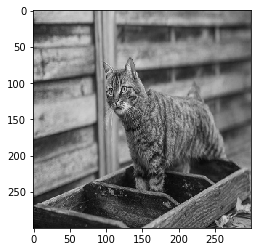

8方向に移動した画像
img_len: 8


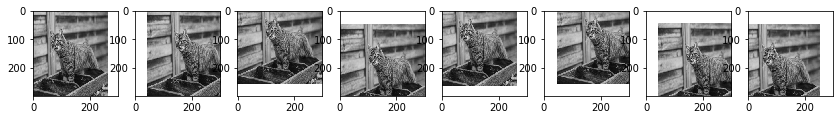

コントラスト変化


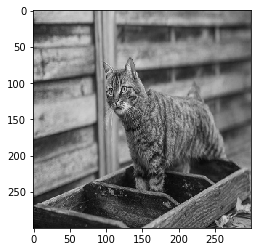

明るさ変換（ガンマ補正）


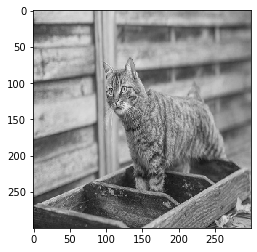

平滑化


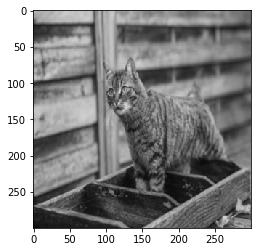

部分マスク


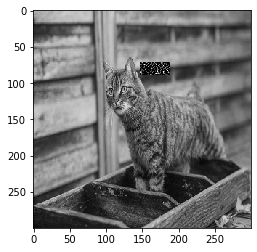

リサイズ（拡大縮小）


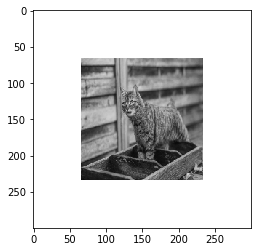

回転画像


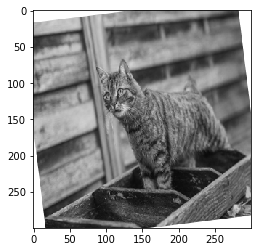

アフィン変換（歪み）


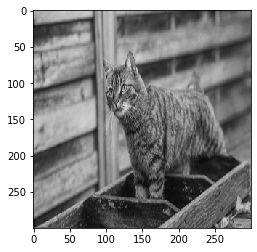

ノイズ付与


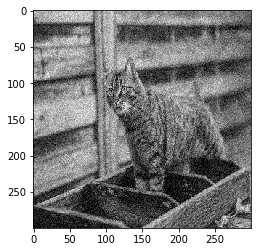

In [75]:
# サンプル画像のパス
file_path = 'data/sample_animal.jpg'
# モノクロ画像として読み込み
img = cv2.imread(file_path, 0)
img = cv2.resize(img, dsize=(300, 300))
#ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
print("モノクロ画像")
show_img(img)

slide_img = generate_slide_img(img)
print("8方向に移動した画像")
show_img(slide_img)

contrast_img = contrast(img)
print("コントラスト変化")
show_img(contrast_img)

gamma_img = gamma(img)
print("明るさ変換（ガンマ補正）")
show_img(gamma_img)

blur_img = blur(img)
print("平滑化")
show_img(blur_img)

mask_img = mask(img)
print("部分マスク")
show_img(mask_img)

resize_img = resize(img)
print("リサイズ（拡大縮小）")
show_img(resize_img)

rotate_img = rotate(img)
print("回転画像")
show_img(rotate_img)

affine_img = affine(img)
print("アフィン変換（歪み）")
show_img(affine_img)

noise_img = gaussian_noise(img)
print("ノイズ付与")
show_img(noise_img)


## 文字画像に対して文字の膨張をテスト

モノクロ画像


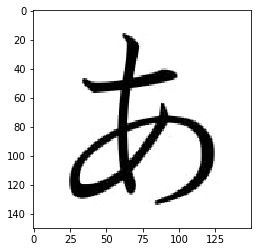

膨張


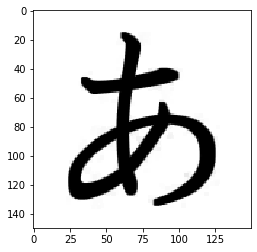

In [52]:
img = cv2.imread('data/sample.jpg', 0)
print("モノクロ画像")
show_img(img)

expansion_img = expansion(img)
print("膨張")
show_img(expansion_img)

## 水増し処理
8方向移動(generate_slide_img)を行った後、移動した画像と移動していない画像に対して下記の関数の処理を行う　itertools.combinationを用いて処理の関数の全組み合わせで水増しを行う。

$$
一枚当たりに増える画像数 = 9*\sum_{i=0}^{8} 8Ci = 2304
$$

【処理の順番】(全ての関数を使う場合)<br>
・移動（generate_slide_img）<br>
・文字の膨張（expansion）（文字画像の場合）<br>
・コントラストを調整（contrast）<br>
・明るさを調整（ガンマ補正）（gamma）<br>
・平滑化（平均化フィルタ）（blur）<br>
・部分マスク（mask）<br>
・拡大縮小(リサイズ)（resize）<br>
・回転（rotate）<br>
・アフィン変換（歪み）（affine）<br>
・ノイズを増やす（gaussian_noise）<br>


In [101]:
'''
フォルダ内の画像を水増しする関数
data_pathディレクトリ内の画像を処理してwrite_pathディレクトリに保存する
'''
data_path = 'data/samples' # 元データのディレクトリ
write_path = 'data/results' # 処理後データのディレクトリ

# 処理関数のリスト（処理をかける順）
#process_func_list = [expantion, contrast, gamma, blur, mask, resize, rotate, affine, gaussian_noise] # 文字画像の場合
process_func_list = [contrast, gamma, blur, mask, resize, rotate, affine, gaussian_noise]

file_paths = glob.glob(data_path+'/*')
print("読み込みデータ", file_paths)
os.makedirs(write_path, exist_ok=True)
for file_path in file_paths:
    fname = os.path.basename(file_path.split('.')[0]) # 保存用ファイル名の取得
    print(fname)
    img = cv2.imread(file_path, 0) # 画像のモノクロ読込
    img = cv2.resize(img, dsize=(300, 300))

    slide_imgs = generate_slide_img(img) # 移動したデータの作成
    slide_imgs.append(img) # 移動していないデータも追加
    
    count = 0
    for fore_img in slide_imgs:
        for i in range(len(process_func_list)+1):
            # 関数リストからi個の関数の組合せ生成、列挙
            for pair in itertools.combinations(process_func_list, i):
                processed_img = fore_img
                 # 画像を処理にかける
                if len(pair) != 0:
                    for func in pair:
                        processed_img = func(processed_img)

                # 画像を保存する
                cv2.imwrite(write_path+'/'+fname+'_'+str(count)+'.jpg', processed_img)
                count += 1
            
print("end")


読み込みデータ ['data/samples\\sample_animal.jpg']
sample_animal
end
